In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25})
import json
import glob
import pickle

In [2]:
file_name = 'data_files/all_phens_covs.json'
with open(file_name, 'r') as json_file:
    covariances_list = json.load(json_file)

In [3]:
phenotype_of_interest = np.array(['Daysinmilk', 'Liveweightkg', 'OM1', 'CP1', 'NDF1', 'Starch1',
       'DM2', 'Milk', 'Fat', 'Protein', 'Lactose', 'FCM',
       'EnergycorrectedmilkECM', 'Fatgkg', 'Proteingkg', 'Lactosegkg',
       'ECMDMI', 'NRC_DMI', 'FCEecm', 'FCEfcm', 'FCEsolids',
       'RumenpH', 'TotalVFA', 'Acetate', 'Propionate', 'Butyrate',
       'Isobutyrate', 'Valerate', 'Isovalerate', 'Ammonia', 'gd',
       'gkgDMI', 'gkgECM', 'NEFA', 'BHB', 'Glucose', 'Urea',
       'Cholesterol', 'Creatinine', 'Albumin',
       'protozoa_count_mean', 'archaea_count_mean', 'bacteria_count_mean'], dtype='<U22')

In [4]:
phenotype_cov = {x: [] for x in phenotype_of_interest}
for phen in phenotype_of_interest:
    for x in covariances_list:
        phenotype_cov[phen].append(x[phen])

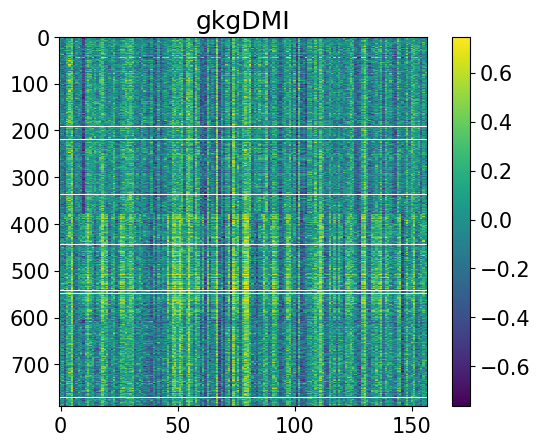

In [18]:
list_unprocessed = []
for phen in ['gkgDMI']:
# for phen in phenotype_of_interest:
    idx = 0
    data = phenotype_cov[phen]
    
    # Check for rows that are just np.nan
    processed_data = []
    for row in data:
        if isinstance(row, float) and np.isnan(row):
            # If the row is a single np.nan, create a row of np.nan values
            processed_data.append([np.nan] * len(data[0]))
            list_unprocessed.append(idx)
        else:
            processed_data.append(row)
        idx +=1
    
    # Convert the processed data back to a numpy array
    processed_data = np.array(processed_data)
    
    # Mask the NaN values
    masked_data = np.ma.masked_invalid(processed_data)
    
    plt.imshow(masked_data, interpolation='none', cmap='viridis', aspect=0.2)  # or your preferred colormap
    plt.colorbar()
    plt.title(phen)
    plt.show()

In [7]:
len(list_unprocessed)

22

In [8]:
len(phenotype_cov["gkgDMI"])

790

In [5]:
for phen in phenotype_of_interest:
    # Check for rows that are just np.nan
    for i in range(len(phenotype_cov[phen])):
        if isinstance(phenotype_cov[phen][i], float) and np.isnan(phenotype_cov[phen][i]):
            # If the row is a single np.nan, create a row of np.nan values
            phenotype_cov[phen][i] = [np.nan] * len(phenotype_cov[phen][0])

In [10]:
nan_row_indices = [i for i in range(np.array(phenotype_cov["gkgDMI"]).shape[0]) if np.all(np.isnan(np.array(phenotype_cov["gkgDMI"])[i]))]
print(nan_row_indices)

[1, 46, 193, 220, 271, 281, 338, 395, 397, 445, 461, 488, 491, 543, 549, 578, 582, 616, 634, 693, 742, 771]


In [6]:
non_nan_row_indices = [i for i in range(np.array(phenotype_cov["gkgECM"]).shape[0]) if not np.all(np.isnan(np.array(phenotype_cov["gkgECM"])[i]))]
cov_data = {phen: np.array(phenotype_cov[phen])[non_nan_row_indices, :-1] for phen in phenotype_of_interest}

In [21]:
cov_data['gkgDMI'].shape

(768, 156)

# Clustering gkgDMI and coloring samples based on their farm

In [13]:
data_path = '/home/ks2823/my_CRM/Data/three_kingdoms_python_friendly.pkl'

with open(data_path, 'rb') as fp:
    cow_full_data = pickle.load(fp)

farm = cow_full_data['cow_farm'].reshape(-1)
farm_1 = farm[cow_full_data['cow_species'].reshape(-1)==1]

row_categories = farm_1[non_nan_row_indices]

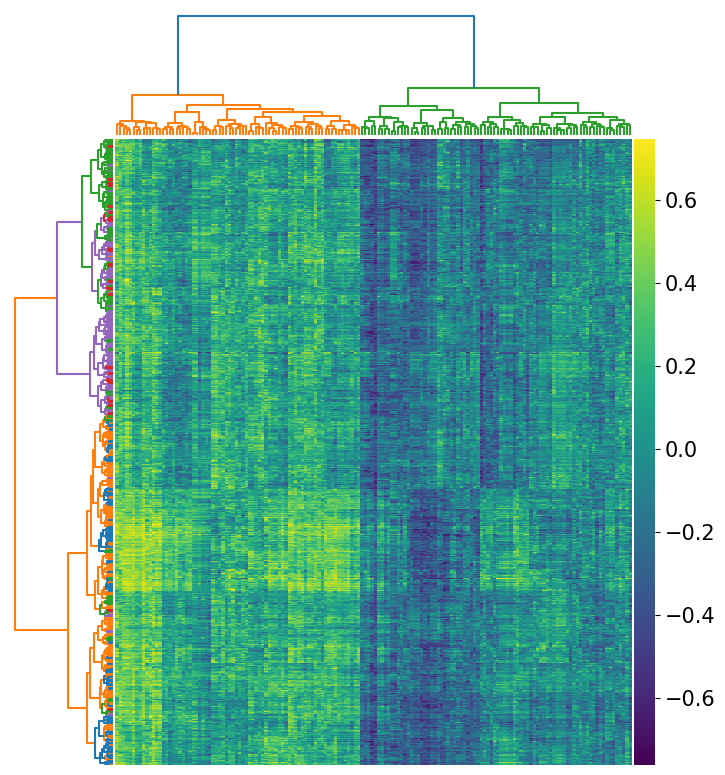

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import Counter

def correct_linkage_indices(linkage_matrix, num_points):
    """
    Corrects the indices in the linkage matrix for plotting a dendrogram with color categories.
    
    Parameters:
    - linkage_matrix: The linkage matrix obtained from hierarchical clustering.
    - num_points: The number of points (rows or columns) in the data matrix.

    Returns:
    - corrected_linkage: The corrected linkage matrix with updated indices.
    - cluster_ids: A dictionary mapping cluster IDs to the original data indices.
    """
    cluster_ids = {i: [i] for i in range(num_points)}
    next_cluster_id = num_points
    corrected_linkage = []

    for i, (cluster1, cluster2, dist, sample_count) in enumerate(linkage_matrix):
        cluster1 = int(cluster1)
        cluster2 = int(cluster2)
        cluster_ids[next_cluster_id] = cluster_ids[cluster1] + cluster_ids[cluster2]
        corrected_linkage.append([cluster1, cluster2, dist, sample_count])
        next_cluster_id += 1

    return np.array(corrected_linkage), cluster_ids

def get_color_from_indices(cluster_id, cluster_ids, categories, category_colors):
    """
    Returns the color for a given cluster ID based on the most common category in the cluster.
    
    Parameters:
    - cluster_id: The ID of the cluster.
    - cluster_ids: A dictionary mapping cluster IDs to the original data indices.
    - categories: The categories of the original data points.
    - category_colors: A dictionary mapping categories to colors.

    Returns:
    - The color corresponding to the cluster ID.
    """
    original_indices = cluster_ids[cluster_id]
    cluster_categories = [categories[idx] for idx in original_indices]
    most_common_category = Counter(cluster_categories).most_common(1)[0][0]
    return mcolors.to_hex(category_colors[most_common_category])


# Create a color palette
unique_categories = list(set(row_categories))
palette = sns.color_palette("tab10", len(unique_categories))

# Create a dictionary mapping categories to colors
category_colors = {cat: palette[i] for i, cat in enumerate(unique_categories)}

gkgDMI = np.copy(cov_data["gkgDMI"])

# Perform hierarchical clustering on rows and columns
row_linkage = linkage(gkgDMI, method='ward')
col_linkage = linkage(gkgDMI.T, method='ward')

# Correct the linkage matrix indices
corrected_row_linkage, cluster_ids = correct_linkage_indices(row_linkage, gkgDMI.shape[0])

# Plot the dendrogram with corrected indices
fig, axs = plt.subplots(2, 3, figsize=(7.5, 8), gridspec_kw={'width_ratios': [1, 5, 0.2], 'height_ratios': [1, 5]})

try:
    dendro_rows = dendrogram(
        corrected_row_linkage,
        ax=axs[1, 0],
        orientation='left',
        no_labels=True,
        link_color_func=lambda k: get_color_from_indices(k, cluster_ids, row_categories, category_colors)
    )
    row_order = dendro_rows['leaves']
    # print("Row order:", row_order)

except IndexError as e:
    print("An error occurred while plotting the dendrogram:", e)
    # Additional debug information
    print("Linkage matrix:", corrected_row_linkage)
    print("Data shape:", gkgDMI.shape)

# Remove distance values from the row dendrogram
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# Plot the dendrogram for columns
dendro_cols = dendrogram(col_linkage, ax=axs[0, 1], no_labels=True)
col_order = dendro_cols['leaves']

# Remove distance values from the column dendrogram
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# Reorder the matrix
clustered_gkgDMI = gkgDMI[row_order, :]
clustered_gkgDMI = clustered_gkgDMI[:, col_order]

# Plot the clustered heatmap
sns.heatmap(clustered_gkgDMI, cmap='viridis', ax=axs[1, 1], cbar_ax=axs[1, 2], xticklabels=False, yticklabels=False)

# Remove the borders for axs[0, 1] and axs[1, 0]
for spine in axs[0, 1].spines.values():
    spine.set_visible(False)
for spine in axs[1, 0].spines.values():
    spine.set_visible(False)

# Remove the empty placeholders
axs[0, 0].remove()
axs[0, 2].remove()

# Adjust the space between the top and bottom plots
fig.tight_layout()
fig.subplots_adjust(hspace=0.01, wspace=0.01)
plt.savefig('figures/reviewer_fig_4_a.pdf', format='pdf')
plt.show()


In [40]:
category_colors

{'UK2': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'UK1': (1.0, 0.4980392156862745, 0.054901960784313725),
 'IT2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'IT3': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'IT1': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

In [39]:
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

# variation vs local strenght of different otus for gkgdmi

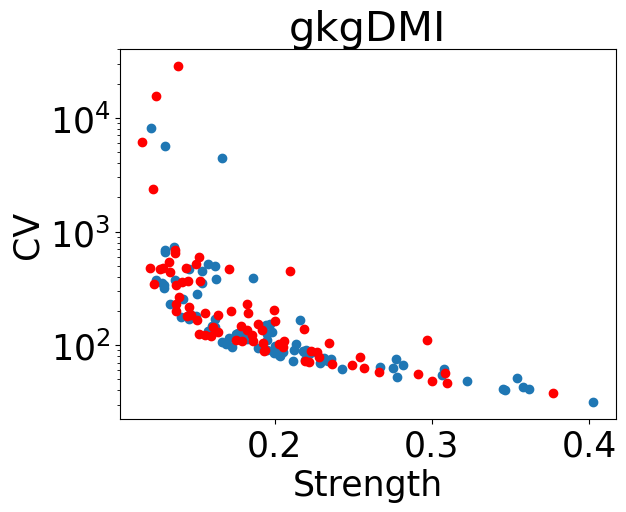

In [14]:
for phen in ['gkgDMI']:
    phen_otu = np.copy(cov_data[phen]).T

    strength = np.array([np.mean(np.abs(otu)) for otu in phen_otu])
    variance = np.array([100*np.std(otu)/np.mean(otu) for otu in phen_otu])

    plt.scatter(strength[variance > 0], variance[variance > 0], label='positive CV')
    plt.scatter(strength[variance < 0], -variance[variance < 0], color='red', label='negative CV')
    # plt.ylim(50, 1000)
    plt.xlabel('Strength')
    plt.ylabel('CV')
    plt.yscale('log')
    # plt.legend()
    plt.title(phen)
    # plt.xlim(0.205, 0.215)
    plt.show()

In [15]:
gkgDMI = np.copy(cov_data["gkgDMI"])
assert gkgDMI.shape[1] == 156

# Calculate the mean and coefficient of variation for OTUs
gkgDMI_otu_strength = np.mean(np.abs(gkgDMI), axis=0)
gkgDMI_otu_cv = 100 * np.std(gkgDMI, axis=0) / np.mean(gkgDMI, axis=0)

In [16]:
# Find the location of OTUs based on given conditions
otu_1_loc = np.where((gkgDMI_otu_strength > 0.208) & 
                     (gkgDMI_otu_strength < 0.212) & 
                     (gkgDMI_otu_cv > -1000) & 
                     (gkgDMI_otu_cv < -300))[0][0]

# Get the OTU data for the found locations
otu_1 = gkgDMI.T[otu_1_loc, :]

# Find the location of OTUs based on given conditions
otu_2_loc = np.where((gkgDMI_otu_strength > 0.210) & 
                     (gkgDMI_otu_strength < 0.212) & 
                     (gkgDMI_otu_cv > 50) & 
                     (gkgDMI_otu_cv < 100))[0][0]

# Get the OTU data for the found locations
otu_2 = gkgDMI.T[otu_2_loc, :]

In [80]:
survived_indices = np.loadtxt("data_files/cow_survived_indices.csv", delimiter=",", dtype=int)
taxonomy = pd.read_csv('data_files/taxonomy.csv')
taxonomy.replace('<undefined>', np.nan, inplace=True)
taxonomy = taxonomy.drop('VarName1', axis=1)
taxonomy = np.array(taxonomy)
# print(taxonomy[otu_1_loc])
# print(taxonomy[otu_2_loc])

/tmp/tmp.MaBRgFmtH2/ipykernel_2450373/3262067119.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  survived_indices = np.loadtxt("data_files/cow_survived_indices.csv", delimiter=",", dtype=int)


0.2095946483164304 -453.51565272429633
0.21184700943170498 72.46871161623436


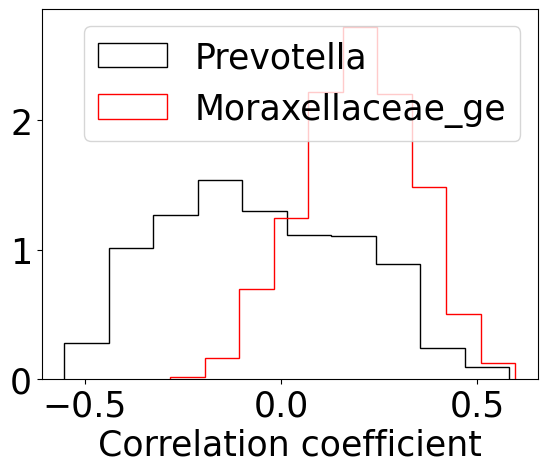

In [18]:
for x, color in zip([otu_1_loc, otu_2_loc], ['black', 'red']):
    plt.hist(gkgDMI.T[x, :], histtype='step', label=taxonomy[x][-2], color=color, density=True)
    print(gkgDMI_otu_strength[x], gkgDMI_otu_cv[x])
    # plt.show()
plt.xlabel('Correlation coefficient')
plt.legend()
# plt.savefig('figures/reviewer_fig_4_b.pdf', format='pdf')
plt.show()

# Global vs local strength correlation

In [7]:
reduced_metnames = [['Propionate'            ],
    # ['A2BRatio'              ],
    ['Glucose'               ],
    ['NEFA'                  ],
    ['Lactosegkg'            ],
    ['RumenpH'               ],
    ['Starch1'               ],
    ['Valerate'              ],
    ['Lactose'               ],
    ['TotalVFA'              ],
    ['archaea_count_mean'    ],
    ['EnergycorrectedmilkECM'],
    ['Creatinine'            ],
    ['FCM'                   ],
    ['NRC_DMI'               ],
    ['Fat'                   ],
    ['Milk'                  ],
    ['Protein'               ],
    ['DM2'                   ],
    ['Urea'                  ],
    ['Daysinmilk'            ],
    ['gkgECM'                ],
    ['Isobutyrate'           ],
    ['Ammonia'               ],
    ['ECMDMI'                ],
    ['FCEfcm'                ],
    ['Acetate'               ],
    ['FCEecm'                ],
    ['BHB'                   ],
    ['FCEsolids'             ],
    ['Cholesterol'           ],
    ['Butyrate'              ],
    # ['RFINRC'                ],
    ['protozoa_count_mean'   ],
    ['Liveweightkg'          ],
    # ['Haptoglobulin'         ],
    ['Albumin'               ],
    ['Proteingkg'            ],
    ['gkgDMI'                ],
    ['bacteria_count_mean'   ],
    ['gd'                    ],
    ['OM1'                   ],
    ['Fatgkg'                ],
    ['CP1'                   ],
    ['Isovalerate'           ],
    ['NDF1'                  ]]

In [8]:
data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))[:, :-1]
metadata = np.array(pd.read_csv('data_files/metadata_cow_1.csv', index_col=0))
metnames = np.array(pd.read_csv('data_files/metnames.csv', index_col=0)).reshape(-1)
metnames = np.array([elem.replace("'", "").strip("[]") for elem in metnames])

metadata = metadata[:, np.isin(metnames, reduced_metnames)]
metnames = metnames[np.isin(metnames, reduced_metnames)]

metadata_z_scored = (metadata - metadata.mean(axis=0)[np.newaxis, :])/metadata.std(axis=0)[np.newaxis, :]

plt.figure(figsize=(12, 10))

# x = np.linspace(np.min(global_list), np.max(global_list), 100)
x = np.linspace(-1,1,100)

plt.plot(x, x, '--', color='black')

# Create a density plot
sns.kdeplot(x=global_list, y=local_list, cmap="Reds", thresh=0, levels=15)
plt.scatter(global_list, local_list, color='orange', alpha=0.3)
# Calculate the best fit line
slope, intercept = np.polyfit(global_list, local_list, 1)
best_fit_line = slope * x + intercept

plt.plot(x, best_fit_line, '--', color='red')
local_list = np.array(local_list)
global_list = np.array(global_list)

# Calculate distances from the y = x line
distances = np.abs(local_list - global_list) / np.sqrt(2)

# Find the indices of the two largest distances
outlier_indices = np.argsort(distances)[-2:]


# # Highlight the outliers on the plot and draw boxes around them
# for idx in outlier_indices:
#     plt.scatter(global_list[idx], local_list[idx], color='blue', s=100, edgecolor='black')
#     # Draw a small box around the outliers
#     box_size = 0.08  # Size of the box
#     plt.gca().add_patch(plt.Rectangle((global_list[idx] - box_size / 2, local_list[idx] - box_size / 2),
#                                       box_size, box_size, fill=False, edgecolor='blue', linewidth=2))

plt.xlabel('Global correlation strength')
plt.ylabel('Local correlation strength')
# plt.xlim(np.min(global_list), np.max(global_list))
# plt.ylim(np.min(local_list), np.max(local_list))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
# plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('figures/local_vs_global_strength.pdf', format='pdf')
plt.show()

print(f"Slope of the best fit line: {slope:.2f}")

In [9]:
with open("/home/ks2823/palmer_scratch/my_object.pkl", "rb") as f:
    obj = pickle.load(f)

In [10]:
obj.create_in_silico_samples(1e5)

In [11]:
obj.gm_meta.shape

(75283, 43)

In [23]:
np.corrcoef(data[:, otu_1_loc], metadata[:, np.where(metnames == 'gkgDMI')[0][0]])

array([[1.        , 0.15452132],
       [0.15452132, 1.        ]])

In [24]:
np.corrcoef(data[:, otu_2_loc], metadata[:, np.where(metnames == 'gkgDMI')[0][0]])

array([[1.        , 0.15170562],
       [0.15170562, 1.        ]])

In [22]:
local_global_dict = {x: 0 for x in phenotype_of_interest}

for phen in phenotype_of_interest:
    phen_otu = np.copy(cov_data[phen]).T

    local_strength = np.array([np.mean(np.abs(otu)) for otu in phen_otu]).reshape(-1)
    global_strength = np.array([np.abs(np.corrcoef(obj.gm_data[:, i], obj.gm_meta[:, metnames==phen].reshape(-1))[0, 1]) for i in range(156)]).reshape(-1)

    local_global_dict[phen] = np.corrcoef(local_strength, global_strength)[0, 1]**2

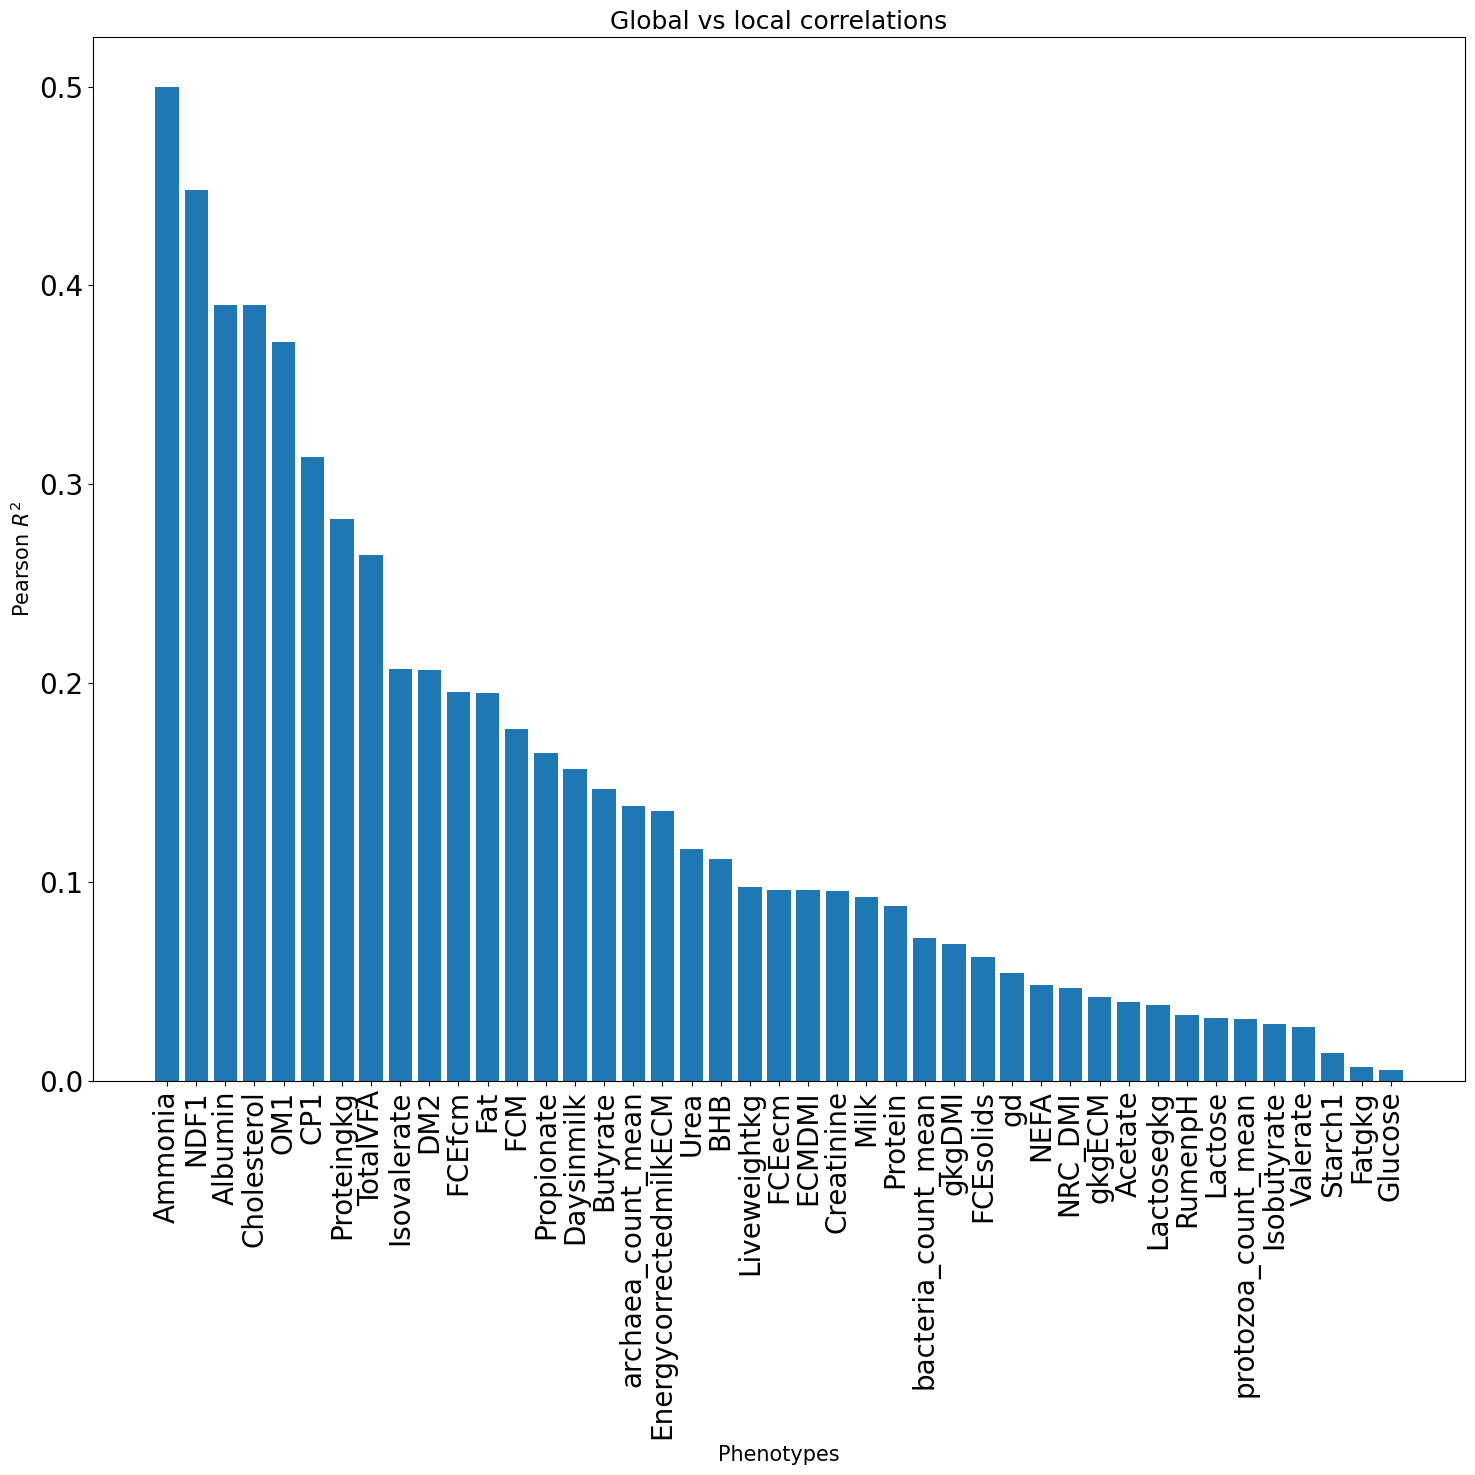

In [23]:
# Extracting keys and values from the dictionary
keys = list(local_global_dict.keys())
values = np.array(list(local_global_dict.values()))

# Sorting the values and rearranging the keys accordingly
sort_idx = np.argsort(values)[::-1]
values = values[sort_idx]
keys = np.array(keys)[sort_idx]

# Creating the figure and setting the figure size
plt.figure(figsize=(15, 15))

# Creating the bar plot
plt.bar(keys, values)

# Set font size for x and y axis labels
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

# Adding labels and title
plt.xlabel('Phenotypes')
plt.ylabel('Pearson $R^2$')
plt.title('Global vs local correlations')

# Rotating the x-axis labels
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('figures/personalized_local_global_correlation.pdf', dpi=300, format='pdf')
# Displaying the plot
plt.show()

In [12]:
local_list = []
global_list = []

for i in range(156):
    for phen in phenotype_of_interest:
        local_list.append(np.mean(cov_data[phen][:, i]))
        global_list.append(np.corrcoef(obj.gm_data[:, i], obj.gm_meta[:, metnames==phen].reshape(-1))[0, 1])


In [13]:
import seaborn as sns

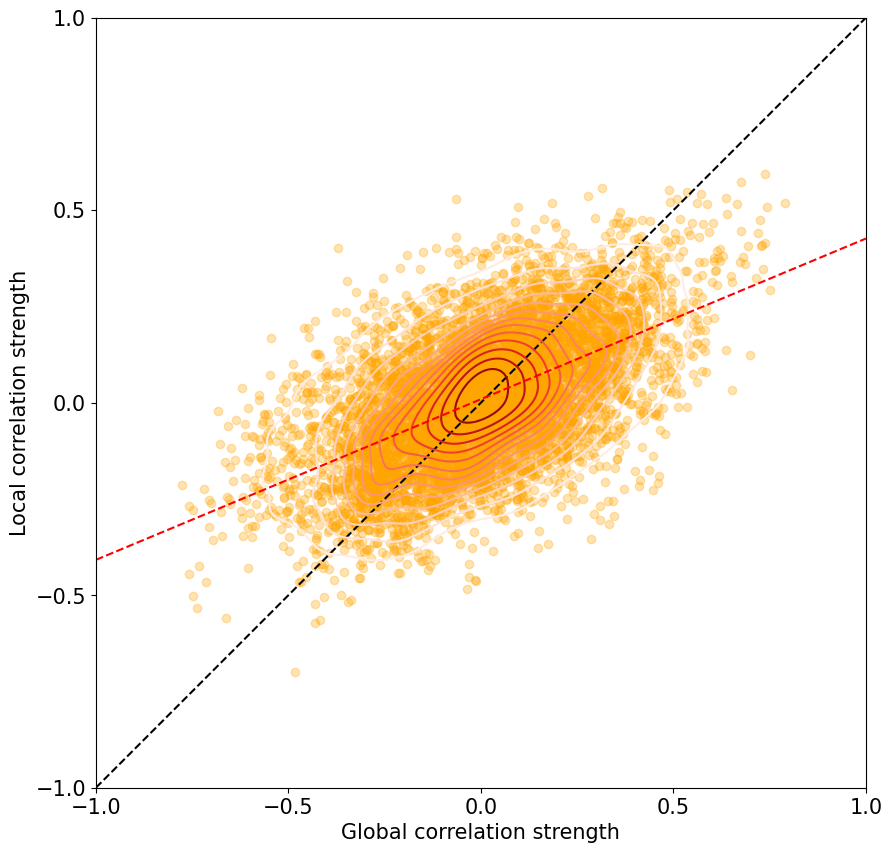

Slope of the best fit line: 0.42


In [14]:
plt.figure(figsize=(12, 10))

# x = np.linspace(np.min(global_list), np.max(global_list), 100)
x = np.linspace(-1,1,100)

plt.plot(x, x, '--', color='black')

# Create a density plot
sns.kdeplot(x=global_list, y=local_list, cmap="Reds", thresh=0, levels=15)
plt.scatter(global_list, local_list, color='orange', alpha=0.3)
# Calculate the best fit line
slope, intercept = np.polyfit(global_list, local_list, 1)
best_fit_line = slope * x + intercept

plt.plot(x, best_fit_line, '--', color='red')
local_list = np.array(local_list)
global_list = np.array(global_list)

# Calculate distances from the y = x line
distances = np.abs(local_list - global_list) / np.sqrt(2)

# Find the indices of the two largest distances
outlier_indices = np.argsort(distances)[-2:]


# # Highlight the outliers on the plot and draw boxes around them
# for idx in outlier_indices:
#     plt.scatter(global_list[idx], local_list[idx], color='blue', s=100, edgecolor='black')
#     # Draw a small box around the outliers
#     box_size = 0.08  # Size of the box
#     plt.gca().add_patch(plt.Rectangle((global_list[idx] - box_size / 2, local_list[idx] - box_size / 2),
#                                       box_size, box_size, fill=False, edgecolor='blue', linewidth=2))

plt.xlabel('Global correlation strength')
plt.ylabel('Local correlation strength')
# plt.xlim(np.min(global_list), np.max(global_list))
# plt.ylim(np.min(local_list), np.max(local_list))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
# plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('figures/local_vs_global_strength.pdf', format='pdf')
plt.show()

print(f"Slope of the best fit line: {slope:.2f}")

In [78]:
outlier_indices

array([24, 91])

In [79]:
# Retrieve the total number of phenotypes
num_phenotypes = len(phenotype_of_interest)

# Identify the corresponding outer loop index (i) and phenotype (phen) for each outlier
outliers_info = []
for idx in outlier_indices:
    outer_loop_index = idx // num_phenotypes  # Integer division to get the outer loop index (i)
    phenotype_index = idx % num_phenotypes  # Modulus to get the phenotype index
    phenotype = phenotype_of_interest[phenotype_index]
    outliers_info.append((outer_loop_index, phenotype))

# Print out the information about the outliers
for i, (outer_idx, phen) in enumerate(outliers_info):
    print(f"Outlier {i+1}:")
    print(f"  Outer loop index (i): {outer_idx}")
    print(f"  Phenotype: {phen}")

Outlier 1:
  Outer loop index (i): 0
  Phenotype: Propionate
Outlier 2:
  Outer loop index (i): 2
  Phenotype: Starch1


In [ ]:
# Identify the corresponding outer loop index (i) and phenotype (phen) for each outlier
outliers_info = []
for idx in outlier_indices:
    outer_loop_index = idx // num_phenotypes  # Integer division to get the outer loop index (i)
    phenotype_index = idx % num_phenotypes  # Modulus to get the phenotype index
    phenotype = phenotype_of_interest[phenotype_index]
    outliers_info.append((outer_loop_index, phenotype))

# Print out the information about the outliers
for i, (outer_idx, phen) in enumerate(outliers_info):
    print(f"Outlier {i+1}:")
    print(f"  Outer loop index (i): {outer_idx}")
    print(f"  Phenotype: {phen}")

In [83]:
for i, (outer_idx, phen) in enumerate(outliers_info):
    print(f"Outlier {i+1}:")
    print(f"  Global correlation strenght: {global_list[outlier_indices[i-1]]}")
    print(f"  Local correlation strenght: {local_list[outlier_indices[i-1]]}")
    print(f"  OTU info: {taxonomy[outer_idx]}")
    print(f"  Phenotype: {phen}")

Outlier 1:
  Global correlation strenght: -0.2673332964988003
  Local correlation strenght: 0.40165581585031535
  OTU info: ['Bacteria' 'Proteobacteria' 'Gammaproteobacteria' 'Aeromonadales'
 'Succinivibrionaceae' 'Succinivibrionaceae_UCG-001' nan]
  Phenotype: Propionate
Outlier 2:
  Global correlation strenght: 0.7682626361129883
  Local correlation strenght: 0.12464747054774876
  OTU info: ['Bacteria' 'Firmicutes' 'Bacilli' 'RF39' 'RF39_fa' 'RF39_ge' nan]
  Phenotype: Starch1


In [85]:
# Assuming global_list and local_list are numpy arrays
indices = np.where((np.array(global_list) > 0.4) & (np.array(local_list) > 0.4))

# Convert indices to a list (if needed) and print them
indices_list = indices[0].tolist()

In [87]:
len(high_list)

17

In [86]:
high_list = []
for idx in indices_list:
    outer_loop_index = idx // num_phenotypes  # Integer division to get the outer loop index (i)
    phenotype_index = idx % num_phenotypes  # Modulus to get the phenotype index
    phenotype = phenotype_of_interest[phenotype_index]
    high_list.append((outer_loop_index, phenotype))

# Print out the information about the outliers
for i, (outer_idx, phen) in enumerate(high_list):
    print(f"High correlations {i+1}:")
    print(f"  Global correlation strenght: {global_list[indices_list[i-1]]}")
    print(f"  Local correlation strenght: {local_list[indices_list[i-1]]}")
    print(f"  OTU info: {taxonomy[outer_idx]}")
    print(f"  Phenotype: {phen}")

High correlations 1:
  Global correlation strenght: 0.48443138050834156
  Local correlation strenght: 0.4403254799926691
  OTU info: ['Bacteria' 'Proteobacteria' 'Gammaproteobacteria' 'Aeromonadales'
 'Succinivibrionaceae' 'Succinivibrionaceae_UCG-001' nan]
  Phenotype: Propionate
High correlations 2:
  Global correlation strenght: 0.7162268150207205
  Local correlation strenght: 0.4100818020406967
  OTU info: ['Bacteria' 'Verrucomicrobiota' 'Kiritimatiellae' 'WCHB1-41' 'WCHB1-41_fa'
 'WCHB1-41_ge' nan]
  Phenotype: Propionate
High correlations 3:
  Global correlation strenght: 0.6025090335317892
  Local correlation strenght: 0.519963708587165
  OTU info: ['Bacteria' 'Bacteroidota' 'Bacteroidia' nan nan nan nan]
  Phenotype: Propionate
High correlations 4:
  Global correlation strenght: 0.5444594914188573
  Local correlation strenght: 0.4142674796795028
  OTU info: ['Bacteria' 'Firmicutes' 'Clostridia' 'Oscillospirales' 'Ruminococcaceae'
 nan nan]
  Phenotype: Propionate
High correlati

# Scatter plot of local and global strengths